In [1]:
import matplotlib.pyplot as plt
import os,glob
import numpy as np
import seaborn as sns
from scipy.special import kn,zetac
import copy
import mypyslha as pyslha
from getContour import getContour
import shutil
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))

## Get CheckMate Output

In [2]:
resultFolder = '../data/checkmate_BS2p'
slhaFolder = '../data/slha_BS2p/'

In [3]:
removeAna = ['atlas_conf_2019_040']

In [4]:
recastData = []
kfactor = 1.5

for slhaFile in glob.glob(slhaFolder+'/*.slha'):
    slhaData = pyslha.readSLHAFile(slhaFile)
    mChi1 = slhaData.blocks['MASS'][5000521]
    mDM = slhaData.blocks['MASS'][5000522]
    resDir = os.path.splitext(os.path.basename(slhaFile))[0]
    resFile = os.path.join(resultFolder,resDir,'evaluation',
                'total_results.txt')

    mgFile = os.path.join(resultFolder,resDir,'mg5amcatnlo',
                'Chi1Chi1_run_card.dat')
    with open(mgFile,'r') as f:
        lines = f.readlines()
        for l in lines:
            if '= nevents' in l: break
        total_evts = eval(l.split('=')[0].strip())
    
    
    #Add point with r=0 to all analyses (default if analysis is missing)
    recastData.append([mChi1,mDM,0.,0.,total_evts])
    
        
    if not os.path.isfile(resFile):
        continue
    data = np.genfromtxt(resFile,names=True,
            dtype=None,encoding=None)

    bestR = 0.0
    bestNevts = 0.0
    for pt in data:
        ana = pt['analysis']
        if ana in removeAna: continue
        r = kfactor*pt['robs']
        nevts = pt['signalsumofweights']
        if r > bestR:
            bestR = r
            bestNevts = float(nevts)
    recastData[-1][2] = bestR
    recastData[-1][3] = bestNevts

In [5]:
recastData = np.array(recastData)

In [6]:
excCurve = np.array(getContour(recastData[:,0],recastData[:,0]-recastData[:,1],recastData[:,2],levels=[1.])[1.],dtype=object)
excCurve = sorted(excCurve[:],key = lambda pt: len(pt),reverse=True)[0] #Select longest curve

### Plot number of events for best analysis/SR

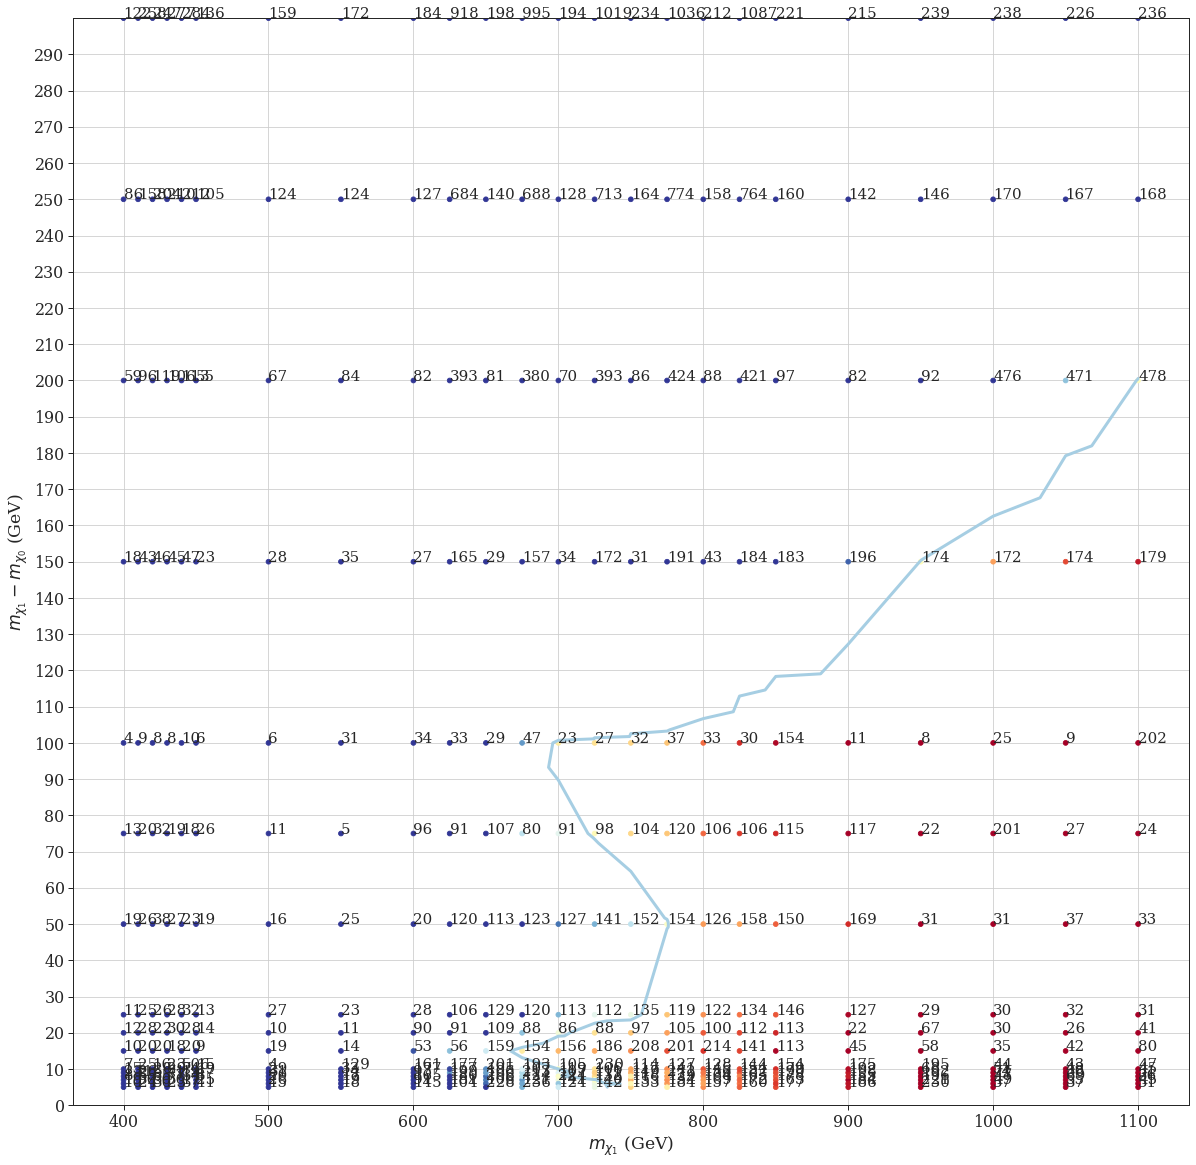

In [16]:
# fig,axes  = plt.subplots(nrows=1,ncols=1,figsize=(10,8))
# ax = axes
ymax = 300.0
fig = plt.figure(figsize=(20,20))
plt.scatter(recastData[:,0],recastData[:,0]-recastData[:,1],c=recastData[:,2],
            cmap=plt.cm.get_cmap('RdYlBu'), vmin=0.3, vmax=1.7)
for pt in recastData:
    if pt[0]-pt[1] > ymax: continue
    plt.annotate('%1.0f'%(pt[3]),(pt[0],pt[0]-pt[1]),
                fontsize=15)
plt.plot(excCurve[:,0],excCurve[:,1],linewidth=3)    
# plt.title(r"$\chi_1 + \bar{\chi}_1 \to c \tau \chi_0 + c \tau \chi_0$ (%s)" %ana,fontsize=11)
plt.xlabel(r'$m_{\chi_1}$ (GeV)')    
plt.ylabel(r'$m_{\chi_1}-m_{\chi_0}$ (GeV)')
plt.ylim(4.,ymax)
plt.yticks(np.arange(0,ymax,10))
plt.grid()
# plt.tight_layout()
plt.show()

### Plot total number of events generated

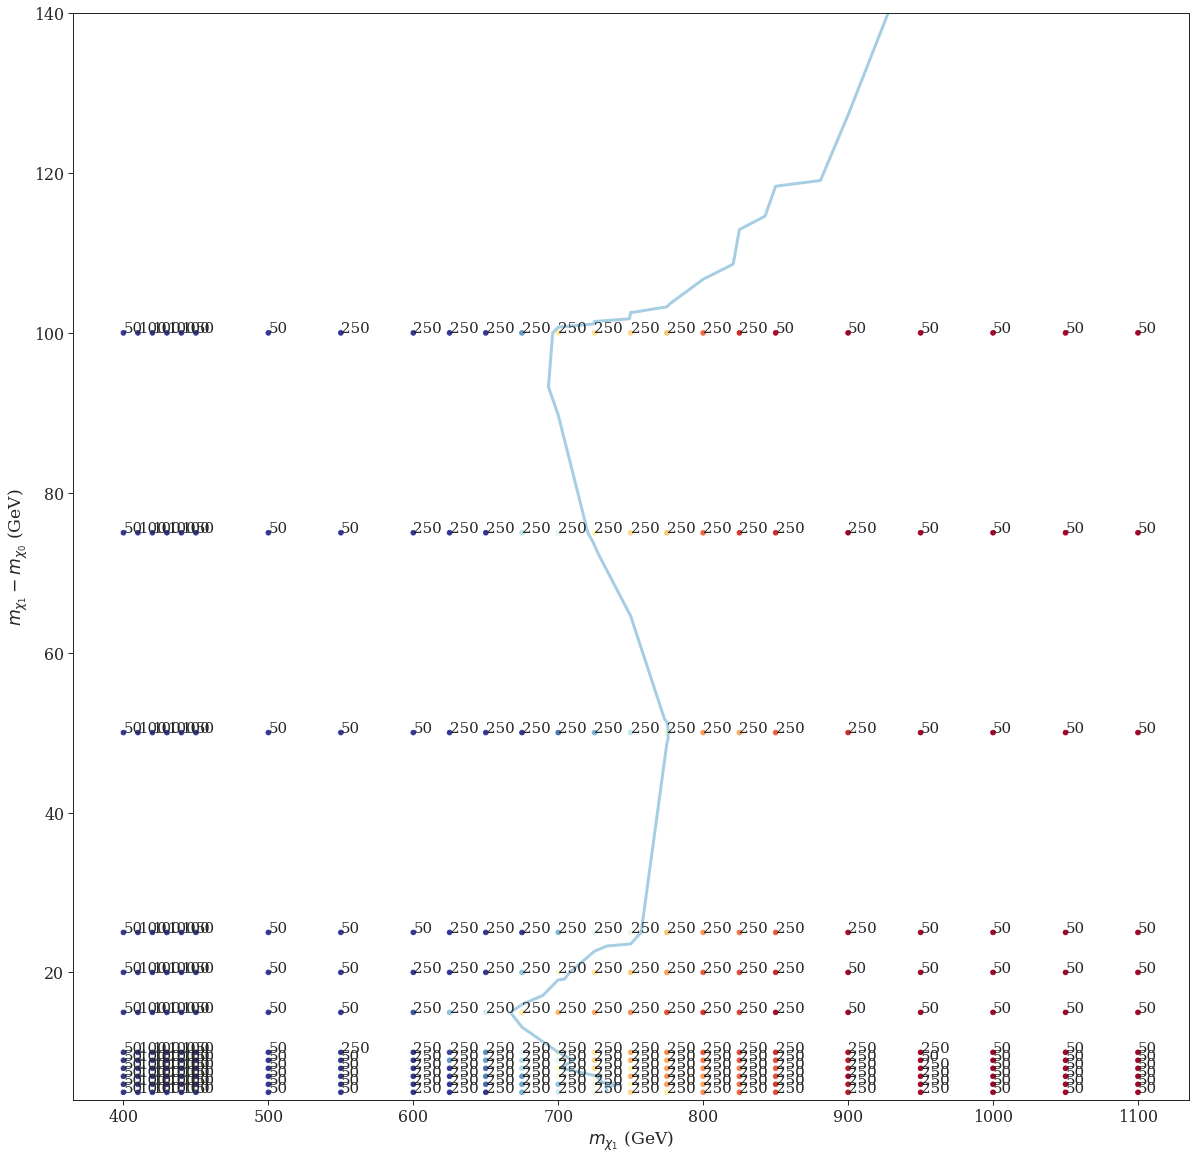

In [8]:
ymax = 140.0
fig = plt.figure(figsize=(20,20))
plt.scatter(recastData[:,0],recastData[:,0]-recastData[:,1],c=recastData[:,2],
            cmap=plt.cm.get_cmap('RdYlBu'), vmin=0.3, vmax=1.7)
for pt in recastData:
    if pt[0]-pt[1] > ymax: continue
    plt.annotate('%1.0f'%(pt[4]/1000.0),(pt[0],pt[0]-pt[1]),
                fontsize=15)
plt.plot(excCurve[:,0],excCurve[:,1],linewidth=3)    
# plt.title(r"$\chi_1 + \bar{\chi}_1 \to c \tau \chi_0 + c \tau \chi_0$ (%s)" %ana,fontsize=11)
plt.xlabel(r'$m_{\chi_1}$ (GeV)')    
plt.ylabel(r'$m_{\chi_1}-m_{\chi_0}$ (GeV)')
plt.ylim(4.,ymax)
# plt.tight_layout()
plt.show()

### Single out points with low stats

In [13]:
lowStats = []
for pt in recastData:
    if abs(pt[2]-1.0) > 0.7: continue
    if pt[3] > 100: continue
    if pt[4] >= 300000: continue
    lowStats.append(pt.tolist())

In [14]:
print(len(lowStats))

17


In [15]:
slhaLow = '../data/slha_BS2p_lowStats/'
for pt in lowStats:
    slhaFile = 'BS2p_Mchi1_%i_Mchi0_%i.slha' %(pt[0],pt[1])
    shutil.copyfile(os.path.join(slhaFolder,slhaFile),os.path.join(slhaLow,slhaFile))